# Image Classification for Room Cleanliness Using Logistic Regression
### Daniyal Mehraeen

### Part a)

In [1]:
! pip install opencv-python

import cv2
import pandas as pd
import os
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Defaulting to user installation because normal site-packages is not writeable


In [2]:
def resize_images(path, target_size):
    
    features = []
    labels = []
    
    for dir in os.listdir(path):
        images_path = os.path.join(path, dir)
        image_class = dir

        image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        for image_file in image_files:
            # Read the image using OpenCV
            image = cv2.imread(os.path.join(images_path, image_file))
            if image is not None:
                # Resize the image to the target size
                resized_image = cv2.resize(image, target_size)

                # Normalize the image
                normalized_image = resized_image.astype(np.float32) / 255.0

                # Flatten the image into a feature vector
                feature_vector = normalized_image.flatten()

                features.append(feature_vector)
                labels.append(int(image_class=="clean")) # class 0 is messy & class 1 is clean

    return np.array(features), np.array(labels)


path_to_images = "./data"
target_size = (256, 256)

X, y = resize_images(path_to_images, target_size)

### Part b)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
print(X_train.shape, X_test.shape)

(190, 196608) (22, 196608)


### Part c)

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss(h, y):
    return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

def fit(X, y, learning_rate, num_iter):
    intercept = np.ones((X.shape[0], 1))
    X = np.concatenate((intercept, X), axis=1)

    theta = np.zeros(X.shape[1])
    
    for i in range(num_iter):

        print(f"\rTraining the model [ {((i+1)/num_iter)*100: .2f}% ]", end="")

        z = np.dot(X, theta)
        h = sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / y.size
        theta -= learning_rate * gradient
        

    print("\rTraining Completed")

    return theta


def predict_prob(X, theta):
    intercept = np.ones((X.shape[0], 1))
    X = np.concatenate((intercept, X), axis=1)
    return sigmoid(np.dot(X, theta))

def predict(X, theta, threshold):
    return predict_prob(X, theta) >= threshold

theta = fit(X_train, y_train, learning_rate=0.1, num_iter=15000)


Training the model [  0.06% ]

C:\Users\mehra\AppData\Local\Temp\ipykernel_55392\2941105791.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Training Completed [  100.00% ]


In [5]:
preds = predict(X_test, theta, 0.5)
probs = predict_prob(X_test,theta)

In [6]:
accuracy = accuracy_score(y_pred=preds, y_true=y_test)
print(f"Implemented Logistic Regression Accuracy: {accuracy*100}%")

Implemented Logistic Regression Accuracy: 63.63636363636363%


In [7]:
classifier = LogisticRegression(max_iter=15000)

classifier.fit(X_train, y_train)

y_pred_prob = classifier.predict_proba(X_test)[:, 1]

threshold = 0.5 
y_pred = (y_pred_prob >= threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f"sklearn Logistic Regression Accuracy: {accuracy*100: .2f}%")

sklearn Logistic Regression Accuracy:  68.18%


### Part d)

In [8]:
num_thresholds = 1000
thresholds = np.linspace(0, 1, num_thresholds)

best_im_thresh = 0
best_im_acc = 0

best_sk_thresh = 0
best_sk_acc = 0

for idx, thresh in enumerate(thresholds):
    print(f"\rEvaluating [ {((idx+1)*100 / num_thresholds): .2f}% ]", end="")

    im_preds = predict(X_test, theta, thresh)
    
    sk_probs = classifier.predict_proba(X_test)[:, 1]
    sk_preds = (sk_probs >= thresh).astype(int)

    im_accuracy = accuracy_score(y_pred=im_preds, y_true=y_test)
    sk_accuracy = accuracy_score(y_pred=sk_preds, y_true=y_test)

    if im_accuracy > best_im_acc:
        best_im_acc = im_accuracy
        best_im_thresh = thresh
    
    if sk_accuracy > best_sk_acc:
        best_sk_acc = sk_accuracy
        best_sk_thresh = thresh
    
print()
print(f"Best Implemented Logistic Regression Accuracy: {best_im_acc*100: .4f}% with threshold = {best_im_thresh}")
print(f"Best sklearn Logistic Regression Accuracy: {best_sk_acc*100: .4f}% with threshold = {best_sk_thresh}%")

Evaluating [  100.00% ]
Best Implemented Logistic Regression Accuracy:  68.1818% with threshold = 0.995995995995996
Best sklearn Logistic Regression Accuracy:  72.7273% with threshold = 0.007007007007007007%


In [9]:
im_preds = predict(X_test, theta, best_im_thresh)
    
sk_probs = classifier.predict_proba(X_test)[:, 1]
sk_preds = (sk_probs >= best_sk_thresh).astype(int)

im_confusion_mat = confusion_matrix(y_pred=im_preds, y_true=y_test)
sk_confusion_mat = confusion_matrix(y_pred=sk_preds, y_true=y_test)

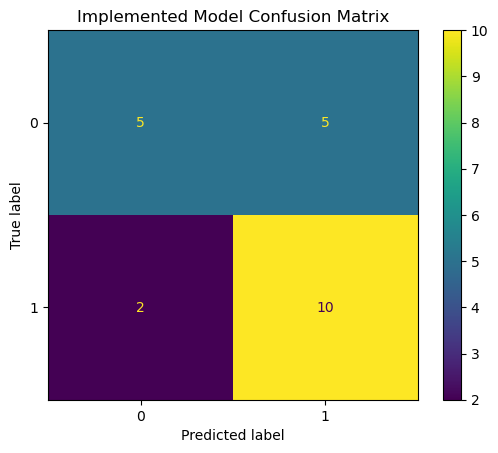

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix=im_confusion_mat, display_labels=[0,1])

disp.plot()
plt.title("Implemented Model Confusion Matrix")
plt.show()

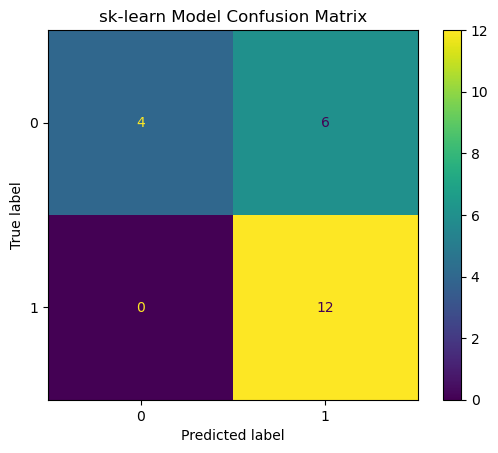

In [11]:
disp = ConfusionMatrixDisplay(confusion_matrix=sk_confusion_mat, display_labels=[0,1])

disp.plot()
plt.title("sk-learn Model Confusion Matrix")
plt.show()

### Part e)

In [12]:
def resize_images(images_path, target_size):
    
    features = []

    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    for image_file in image_files:
        # Read the image using OpenCV
        image = cv2.imread(os.path.join(images_path, image_file))
        if image is not None:
            # Resize the image to the target size
            resized_image = cv2.resize(image, target_size)

            # Normalize the image
            normalized_image = resized_image.astype(np.float32) / 255.0

            # Flatten the image into a feature vector
            feature_vector = normalized_image.flatten()

            features.append(feature_vector)

    return np.array(features)


path_to_images = "./test"
target_size = (256, 256)

X = resize_images(path_to_images, target_size)

In [13]:
y_pred_unknown_data = predict(X, theta, best_im_thresh)

# False is messy and True is clean
pred_label = ["clean" if item else "messy" for item in y_pred_unknown_data]
print(pred_label)

['messy', 'clean', 'messy', 'clean', 'clean', 'clean', 'clean', 'clean', 'clean', 'clean']


In [14]:
true_label = ["clean", "clean", "messy", "clean", "messy", "messy", "clean", "messy", "messy", "clean"]

In [15]:
accuracy = accuracy_score(y_pred=pred_label, y_true=true_label)
print(f"Implemented Logistic Regression Accuracy on the Unknown Data: {accuracy*100}%")

Implemented Logistic Regression Accuracy on the Unknown Data: 50.0%
